<a href="https://colab.research.google.com/github/bartoszkozakiewicz/DeepLearning/blob/main/Food_Vision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!nvidia-smi|

/bin/bash: -c: line 1: syntax error: unexpected end of file


In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-29 12:43:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-29 12:43:22 (130 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [8]:
#Getting helper functions
import helper_functions as hp

In [9]:
#hp.unzip_data("101_food_classes_10_percent.zip")
#train_dir = "101_food_classes_10_percent/train/"
#test_dir = "101_food_classes_10_percent/test"
train_dir="C:/Users/barto/OneDrive/Pulpit/DL_TF/101_food_classes_10_percent/101_food_classes_10_percent/train"
test_dir="C:/Users/barto/OneDrive/Pulpit/DL_TF/101_food_classes_10_percent/101_food_classes_10_percent/test"

In [10]:
#How many images/classes there
hp.walk_through_dir("101_food_classes_10_percent")

In [11]:
#Get tensorflow Datasets
import tensorflow_datasets as tfds

In [12]:
dataset_list=tfds.list_builders()
print("food101" in dataset_list)

True


In [13]:
#Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, #Data gets terutned in tuple format (data,label)
                                             with_info=True) #Meta-data info

In [14]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [15]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [16]:
#Take one sample of train_data
train_one_sample = train_data.take(1) # Foremat (image tensor, label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
for image, label in train_one_sample:
    print(f"Image shape: {image.shape}, \nImage dtype: {image.dtype},\n Target class from food (tensor form): {label}, \nClass name {class_names[label.numpy()]}")

Image shape: (512, 512, 3), 
Image dtype: <dtype: 'uint8'>,
 Target class from food (tensor form): 30, 
Class name deviled_eggs


In [18]:
import tensorflow as tf
#As it can be seen, labels are not onehot encoded
#Check how image look like
image, tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
 array([[[ 28,  31,  50],
         [ 27,  30,  49],
         [ 21,  23,  44],
         ...,
         [ 17,  28,  60],
         [ 20,  30,  65],
         [ 28,  38,  73]],
 
        [[ 11,  14,  33],
         [ 23,  26,  45],
         [ 24,  26,  47],
         ...,
         [ 39,  50,  82],
         [ 33,  44,  76],
         [ 19,  30,  62]],
 
        [[ 16,  17,  37],
         [ 23,  24,  44],
         [ 19,  20,  40],
         ...,
         [ 45,  56,  86],
         [ 39,  50,  80],
         [ 36,  47,  77]],
 
        ...,
 
        [[148,  94, 117],
         [153,  99, 122],
         [153, 102, 121],
         ...,
         [ 94, 128, 166],
         [ 96, 130, 168],
         [ 96, 131, 169]],
 
        [[143,  89, 112],
         [151,  97, 120],
         [153, 102, 121],
         ...,
         [102, 134, 173],
         [103, 135, 174],
         [101, 135, 173]],
 
        [[145,  91, 114],
         [154, 100, 123],
         [158,

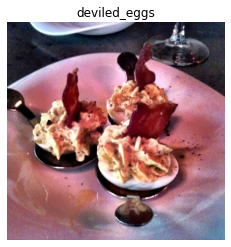

In [19]:
#Plot image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

**PREPROCESS DATA TO MODELS TRAINING**
- Good shape
- Normalize -> between (0-1) generally performs better
- Data type -> models like float32 and with mixed precision float16/float32
- batches? -> Like all of the tensord within a batfch be the same size

**NOW DATA IS**
- In uint8 datatype
- With different size tensors
- Is not scaled              


In [20]:
#EfficientNetBx will be used, which has scaling built in, so rescaling is not needed in this case

#1. Reshape to same size
#2. Convert the dtype of images to float32

In [21]:
#Function to preprocess img
def preprocess_img(image,label,img_shape=224):
    '''
    Convert image datatype to float32 and reshapes
    image to  [img_shape,img_shape,color_channels]
    '''
    
    img=tf.image.resize(image,[img_shape,img_shape])
    return tf.cast(img, tf.float32), label # return (float32_image,label)

In [22]:
#preprocess single sample to check 
preprocessed_image = preprocess_img(image,label)[0]
print(f"Image before prep:\n {image[:2]}... \nShape: {image.shape}\nDatatype: {image.dtype}\n Prep image:\n{preprocessed_image[:2]}...\nShape: {preprocessed_image.shape}\nDatatype:{preprocessed_image.dtype}")

Image before prep:
 [[[28 31 50]
  [27 30 49]
  [21 23 44]
  ...
  [17 28 60]
  [20 30 65]
  [28 38 73]]

 [[11 14 33]
  [23 26 45]
  [24 26 47]
  ...
  [39 50 82]
  [33 44 76]
  [19 30 62]]]... 
Shape: (512, 512, 3)
Datatype: <dtype: 'uint8'>
 Prep image:
[[[21.801022 24.801022 43.80102 ]
  [17.7551   19.7551   40.755104]
  [16.16837  18.16837  41.16837 ]
  ...
  [37.61732  46.831585 75.964294]
  [30.214298 41.2143   72.02044 ]
  [26.163052 36.80591  69.877335]]

 [[22.091837 23.091837 43.09184 ]
  [10.974489 11.974489 31.97449 ]
  [16.112244 17.112244 38.112244]
  ...
  [45.48988  57.48988  81.20421 ]
  [42.413116 54.34169  80.49475 ]
  [33.551304 45.479874 71.76559 ]]]...
Shape: (224, 224, 3)
Datatype:<dtype: 'float32'>


**Batch and prepare datasets**
- input pipelines

Map preprocessing function to training (and parallelize)

In [23]:
#Mapping
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)#PO to, żeby możliwie jak największą
                                                                                         #liczbe chipów CPU wykorzysytwał równolegle
                                                                                         #Po defaultowo tylko 1 i wolniej
#Shuffle train_data and turn it into batches and prefetch it (load faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) 
#shuffle(buffer_size Parameter say how many elements to shuffle in one moment, pamięć RAM może ograniczać ilość, stad nie całość na raz

#Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
#prefetch - while program find patterns in one batch, during that time get another batch ready - pobierać wstępnie
#.catch() - zapisuje co sie dzieje w pamięci RAM, żeby pamietało, ale zapycha to RAM więc zależy

In [24]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Creating model callback

In [25]:
tensorboard_callback = hp.create_tensorboard_callback(dir_name="C:/Users/barto/OneDrive/Pulpit/DL_TF/t_board_food_app",
                               experiment_name="Vision_App")

checkpoint_path = "C:/Users/barto/OneDrive/Pulpit/DL_TF/foodapp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

Saving TensorBoard log files to: C:/Users/barto/OneDrive/Pulpit/DL_TF/t_board_food_app/Vision_App/20230329-124330


**MIXED PRECISION TRAINING**

In [26]:
#Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")#Set global data policy to mixed precision
#For any part of tensorflow models learning if possible it combinates float32 with float16 to speed up model performance
mixed_precision.global_policy()

<Policy "mixed_float16">

**BUILDING FEATURE EXTRACTION MODEL**

In [27]:
from tensorflow.keras.layers.experimental import preprocessing
augmentation_layer = tf.keras.Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip(),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2)
],name="Augmentation_Layer")

In [28]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name="Input_Layer")

#If  scaling woulkd be needed then
#x= preprocessing.Rescaling(1/255.)(X) or in augmentation layer 

#x = augmentation_layer(inputs)
x = base_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="Polling")(x)
x = tf.keras.layers.Dense(101)(x)
outputs = tf.keras.layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)

model = tf.keras.Model(inputs,outputs)

#Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Because this time labeles are not onehot encoded
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Polling (GlobalAveragePooli  (None, 1280)             0         
 ng2D)                                                           
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [30]:
#Check dtype of base model
for layer in base_model.layers:
    print(layer.name,layer.dtype, layer.dtype_policy)

input_1 float32 <Policy "float32">
rescaling float32 <Policy "mixed_float16">
normalization float32 <Policy "mixed_float16">
rescaling_1 float32 <Policy "mixed_float16">
stem_conv_pad float32 <Policy "mixed_float16">
stem_conv float32 <Policy "mixed_float16">
stem_bn float32 <Policy "mixed_float16">
stem_activation float32 <Policy "mixed_float16">
block1a_dwconv float32 <Policy "mixed_float16">
block1a_bn float32 <Policy "mixed_float16">
block1a_activation float32 <Policy "mixed_float16">
block1a_se_squeeze float32 <Policy "mixed_float16">
block1a_se_reshape float32 <Policy "mixed_float16">
block1a_se_reduce float32 <Policy "mixed_float16">
block1a_se_expand float32 <Policy "mixed_float16">
block1a_se_excite float32 <Policy "mixed_float16">
block1a_project_conv float32 <Policy "mixed_float16">
block1a_project_bn float32 <Policy "mixed_float16">
block2a_expand_conv float32 <Policy "mixed_float16">
block2a_expand_bn float32 <Policy "mixed_float16">
block2a_expand_activation float32 <Poli

**FIT THE MODEL**
1. Feature extraction
2. Fine tuning

In [31]:
#Fitting model
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[tensorboard_callback,model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7179 - accuracy: 0.5826

2368/2368 [==============================] - 113s 42ms/step - loss: 1.7179 - accuracy: 0.5826 - val_loss: 1.1208 - val_accuracy: 0.6989
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1987 - accuracy: 0.6900

2368/2368 [==============================] - 99s 41ms/step - loss: 1.1987 - accuracy: 0.6900 - val_loss: 1.0450 - val_accuracy: 0.7153
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0537 - accuracy: 0.7255

2368/2368 [==============================] - 99s 41ms/step - loss: 1.0537 - accuracy: 0.7255 - val_loss: 0.9911 - val_accuracy: 0.7248


In [32]:
model.evaluate(test_data)

790/790 [==============================] - 27s 34ms/step - loss: 0.9971 - accuracy: 0.7281


[0.9971325993537903, 0.7280791997909546]

In [ ]:
tf.keras.models.save_model(model,"food_vision_efficientNet")

In [ ]:
import tensorflow as tf
model_load=tf.keras.models.load_model("food_vision_efficientNet")

In [81]:
test = test_data

In [86]:
labels = []
images = []
for image, label in test:
  labels.append(label.numpy())
  #images.append(image)
len(labels),labels[:10]

(790, [array([ 84,  60,  29,  80,  32,  78,  17,   1,  40,  40,  99,   1,  71,
          42,   6,  44,   1,  75,  61,  74,  54,  76,  34,  90,  15,   4,
          15,  19,  49, 100,  93,  62]),
  array([93, 83, 98, 40, 60, 13, 36, 92, 21, 25, 29, 81, 66, 81,  1, 92, 83,
         16, 60, 32, 36, 94, 48,  0, 65, 29, 56, 37, 87, 65, 64, 26]),
  array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100,   4,  32,  32,
           3,   8,  85,  78, 100,  79,   4,  37,  14,  42,  69,  30,  44,
          17,  44,  22,  77,  17,   6]),
  array([ 83,  80,  45,  28,  23,  30,  72,  45,  94,  92,  46,  18,  99,
          75,  16,  40,  42,  57,  46,  69, 100,  38,  10,  86,  16,  83,
          63,  27,  36,  66,  76,   9]),
  array([65, 70, 34, 69, 23, 78, 13, 41, 27, 41, 32, 25,  5, 20, 53, 59, 37,
         99, 40, 60,  1, 69, 52, 62, 77, 67, 12, 96, 53, 70, 44, 71]),
  array([44, 27, 79, 16, 51, 12, 17, 99, 13, 42, 24, 54, 36, 80, 26, 68, 90,
         33,  9, 12, 78, 77, 96,  6, 48,  9, 38, 74, 52

In [ ]:
labels[2].tolist()

In [106]:
label_all=[]
for i,label in enumerate(labels):
  for x in label.tolist():
    label_all.append(x)
label_all[:10]

[84, 60, 29, 80, 32, 78, 17, 1, 40, 40]

In [117]:
len(label_all)

25250

In [84]:
pred_probs = model.predict(test)

790/790 [==============================] - 26s 32ms/step


In [114]:
#Predicts
predicts = tf.argmax(pred_probs,axis=-1)
predicts[:32]

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([44, 60, 29, 80, 32, 78, 57,  1, 40, 40, 99,  1, 71,  4, 85, 44, 90,
       33,  9,  1, 78, 77, 67,  6,  5, 80, 38, 74, 27,  7, 26, 90])>

In [39]:
#Prediction confidence
pred_conf = np.max(pred_probs,axis=-1)
pred_conf[:20]

array([0.23058651, 0.8517954 , 0.90881914, 0.71647483, 0.9995623 ,
       0.98171633, 0.21300569, 0.9557857 , 0.9604961 , 0.8625739 ,
       0.47911948, 0.82602876, 0.995255  , 0.24160749, 0.7866561 ,
       0.9358572 , 0.2936836 , 0.23565094, 0.670457  , 0.9178985 ],
      dtype=float32)

In [ ]:
from sklearn.metrics import classification_report
#Get dictionary from classification report
class_report_dict = classification_report(y_true=label_all,
                                          y_pred=predicts,
                                          output_dict=True)
class_report_dict

In [ ]:
#Visualize f1 scores with classes
class_f1 = {}
for i,label in enumerate(class_names):
    class_f1[label] = class_report_dict[str(i)]['f1-score']
class_f1

In [110]:
f1_scores = pd.DataFrame({"class_names":list(class_f1.keys()),
                          "f1-score":list(class_f1.values())}).sort_values("f1-score",ascending=False)
f1_scores

,class_names,f1-score
79,prime_rib,0.152542
23,churros,0.150215
53,hamburger,0.142549
29,cup_cakes,0.140625
86,sashimi,0.139630
...,...,...
50,grilled_salmon,0.065385
39,foie_gras,0.062802
0,apple_pie,0.060086
21,chocolate_cake,0.059361


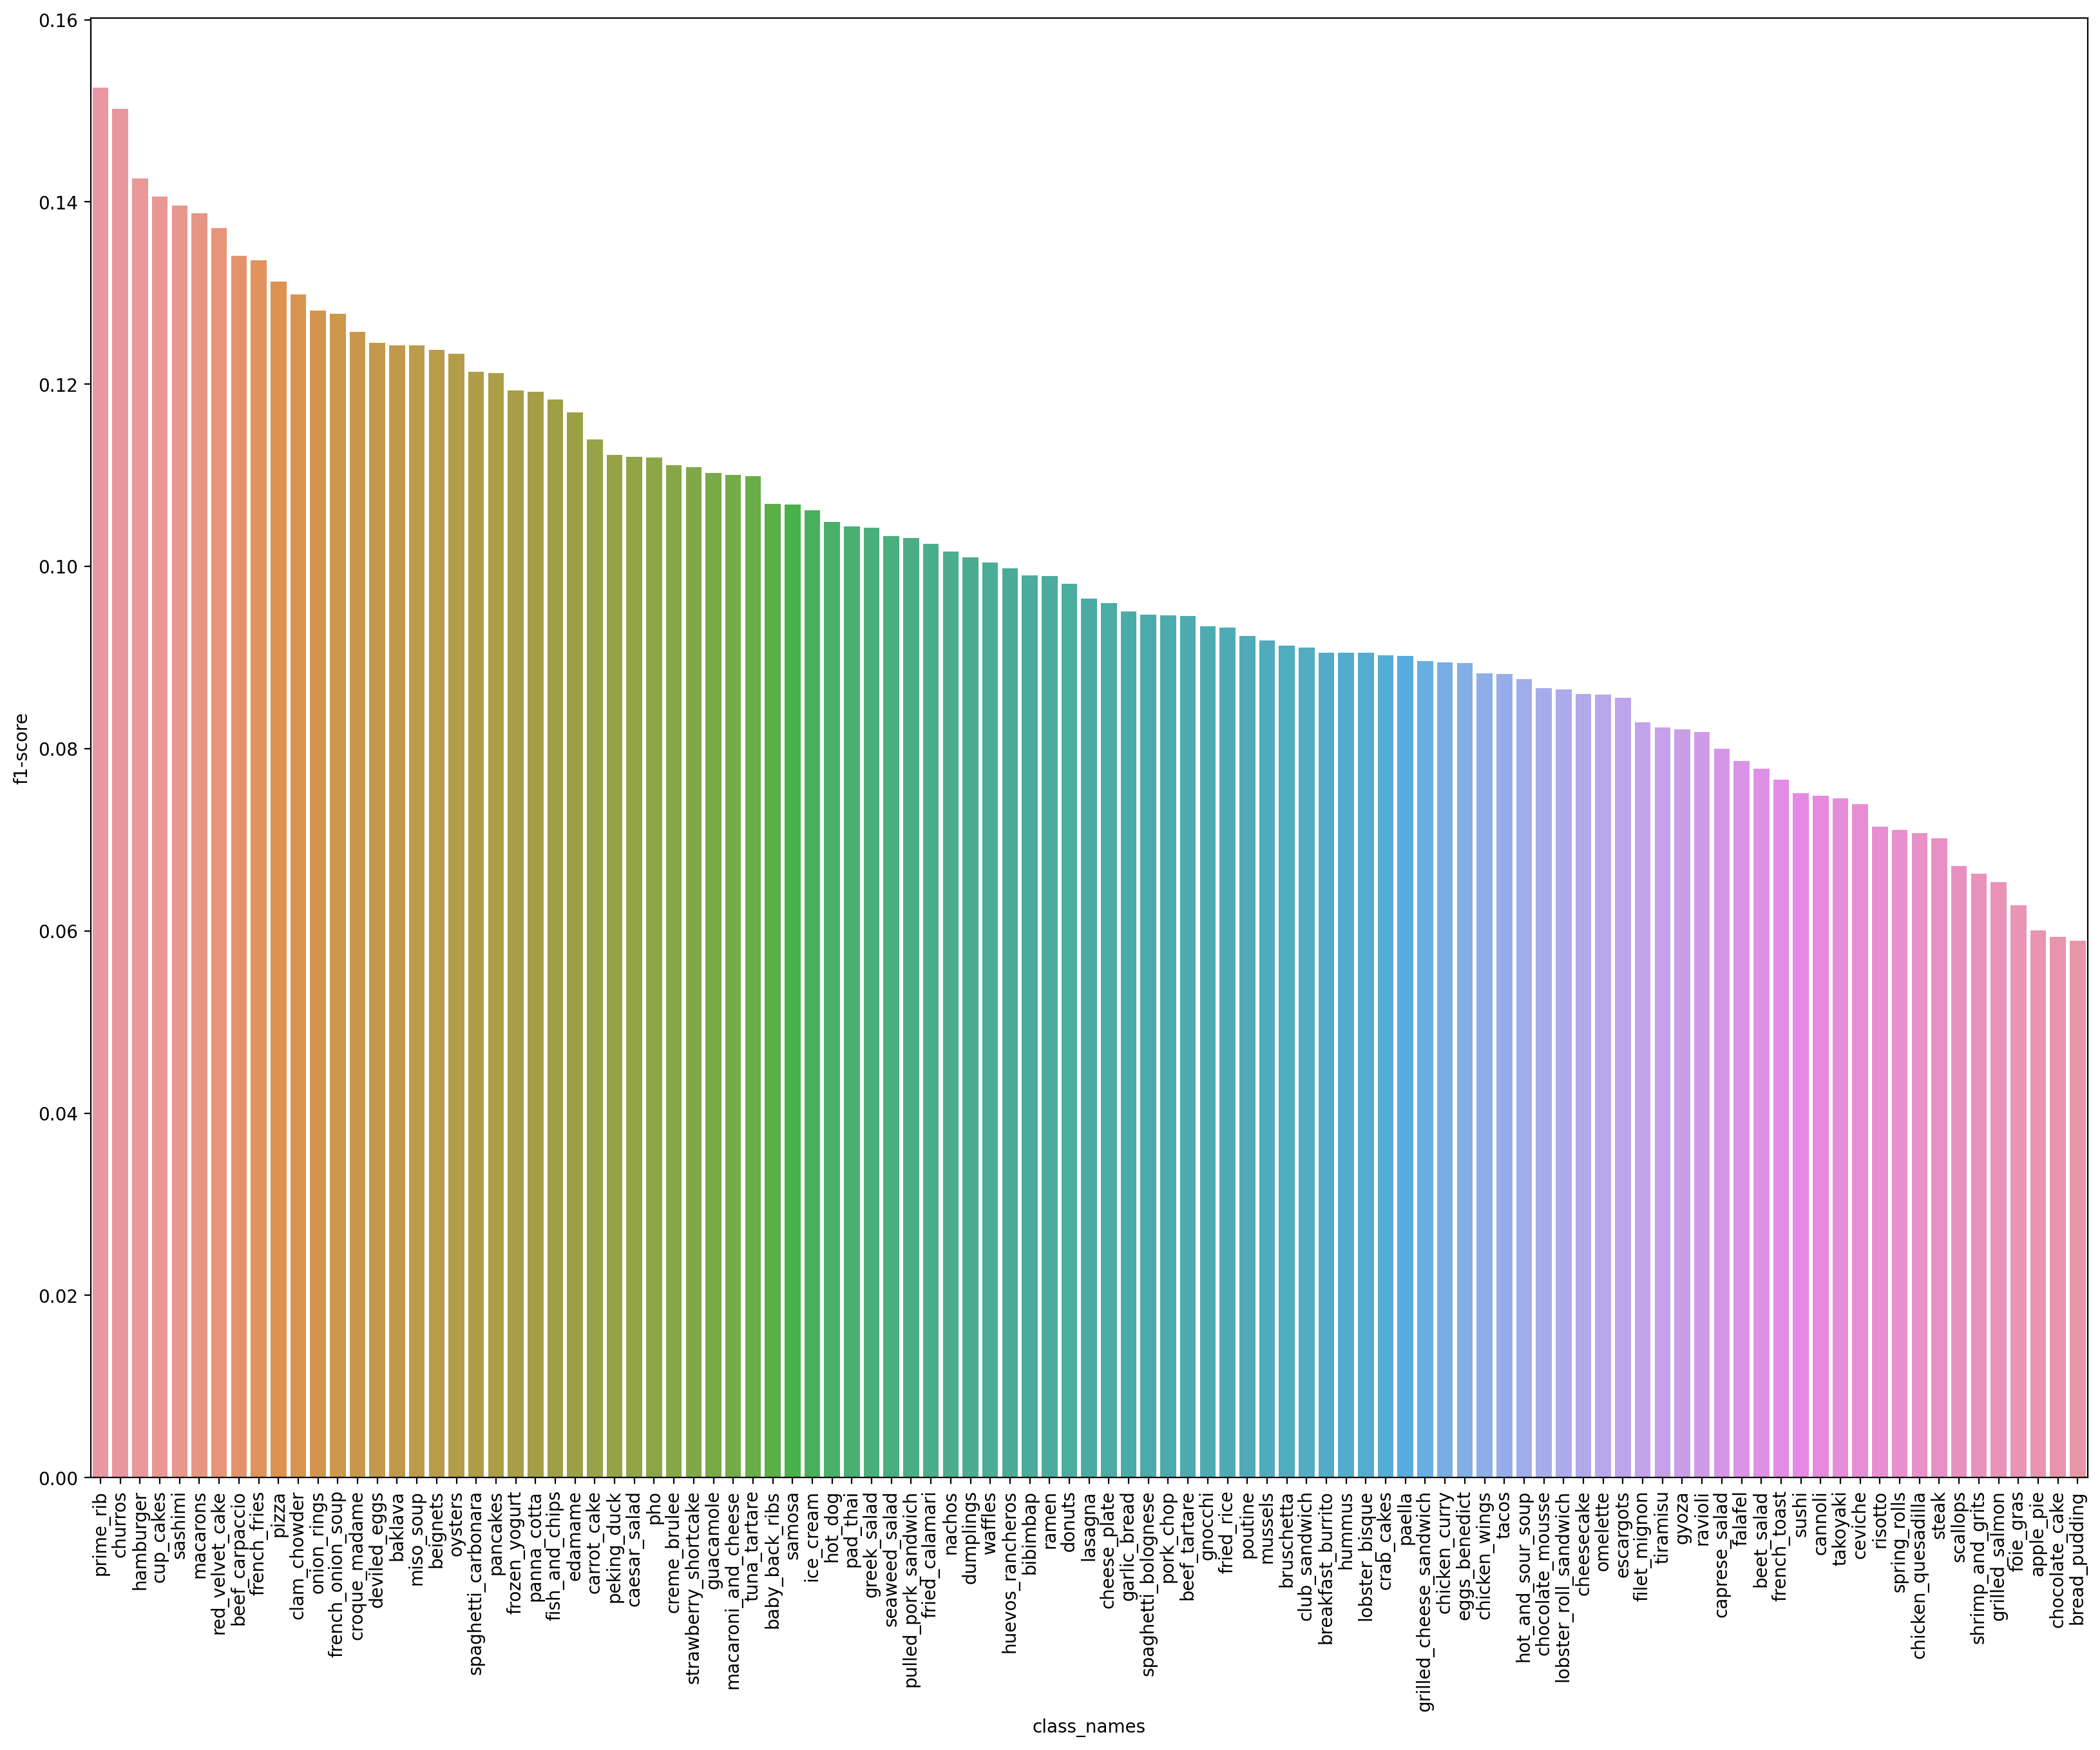

In [111]:
import seaborn as sns
plt.figure(figsize=(20,15), dpi=200)
sns.barplot(f1_scores, x="class_names", y="f1-score",estimator=np.mean)
plt.xticks(rotation=90);

In [ ]:
#Some fixes and visualization of the worst predictions in future